Importing Libraries in Keras, for setting up CNN for Ship Image Detection, We want to create a Sequential NN, Hence we import a Sequential model of the NN, Dense for setting up layers in the NN, 

In [15]:
import json, sys, random
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Flatten, Activation
from keras.layers import Dropout
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.optimizers import SGD
import keras.callbacks
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw 
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
from keras.models import load_model

In the function Below, This is used to get the image in the shape 80*80 basically cutting sections out of the image

In [16]:
def cutting(x, y):
    area_study = np.arange(3*80*80).reshape(3, 80, 80)
    for i in range(80):
        for j in range(80):
            area_study[0][i][j] = picture_tensor[0][y+i][x+j]
            area_study[1][i][j] = picture_tensor[1][y+i][x+j]
            area_study[2][i][j] = picture_tensor[2][y+i][x+j]
    area_study = area_study.reshape([-1, 3, 80, 80])
    area_study = area_study.transpose([0,2,3,1])
    area_study = area_study / 255
    return area_study

In [17]:
def not_near(x, y, s, coordinates):
    result = True
    for e in coordinates:
        if x+s > e[0][0] and x-s < e[0][0] and y+s > e[0][1] and y-s < e[0][1]:
            result = False
    return result

The function below will be used to dray boxes and detect objects in images, Ships in this case

In [18]:
def show_object(x, y, acc, thickness=5):   
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x-th] = -1

    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+i][x+th+80] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y-th][x+i] = -1
        
    for i in range(80):
        for ch in range(3):
            for th in range(thickness):
                picture_tensor[ch][y+th+80][x+i] = -1

In [19]:
#Downloading Dataset from Json File Available in the Download Section
f = open(r'shipsnet.json')
dataset = json.load(f)
f.close()
input_data = np.array(dataset['data']).astype('uint8')
output_data = np.array(dataset['labels']).astype('uint8')
print(input_data.shape)

(3600, 19200)


The DataSet Contains 3600 images and one image is represented by an array of 19200 elements
[[],[],[],[]....[]] A 2-D list with inside lists = 3600 and each list of len 19200 (80x80x3(RGB))

In [20]:
n_spectrum = 3 # color chanel (RGB)
weight = 80
height = 80
X = input_data.reshape([-1, n_spectrum, weight, height])
print(X[0])
print(X[0].shape)

[[[103 104 102 ... 104 105 105]
  [102 104 104 ... 103 104 107]
  [102 103 105 ... 101 103 106]
  ...
  [108  98 100 ... 104 107 107]
  [106 101 103 ... 102 109 114]
  [ 95  98 103 ... 100 105 107]]

 [[108 109 108 ... 109 109 109]
  [108 109 109 ... 108 108 111]
  [108 109 110 ... 106 107 109]
  ...
  [113 101 101 ... 109 110 110]
  [113 107 105 ... 108 113 116]
  [103 105 106 ... 106 110 111]]

 [[ 92  92  91 ...  90  90  90]
  [ 91  92  92 ...  88  89  91]
  [ 91  91  93 ...  86  87  89]
  ...
  [ 95  83  84 ...  90  90  92]
  [ 95  89  88 ...  89  95 100]
  [ 84  88  89 ...  87  91  94]]]
(3, 80, 80)


In [21]:
# This will create a vector for each image representing if there is an image containing ship or not wrt the
# corresponding Index
y = np_utils.to_categorical(output_data, 2)

Randomly Shuffeling the Data to create Randomness so as to train the model better, then normalizing by dividing by 255 as each pixel is represented from a number between 0-255

In [22]:
# shuffle all indexes
indexes = np.arange(2800)
np.random.shuffle(indexes)

X_train = X[indexes].transpose([0,2,3,1])
y_train = y[indexes]

# normalization
X_train = X_train / 255

Creating the Network and training it using the data provided

In [23]:
np.random.seed(42)

# network design
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=(80, 80, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #40x40x32 is the total volume in this layer of convolution
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #20x20x32 is the total volume in this layer of convolution
model.add(Dropout(0.25))

model.add(Conv2D(32, (3, 3), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #10x10x32 is the total volume in this layer of convolution
model.add(Dropout(0.25))

model.add(Conv2D(32, (10, 10), padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2))) #5x5x32 is the total volume in this layer of convolution
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(2, activation='softmax'))

In [24]:
sgd = SGD(lr=0.01, momentum=0.9, nesterov=True)
model.compile(
    loss='categorical_crossentropy',
    optimizer=sgd,
    metrics=['accuracy'])

# training, Uncomment this line in case of training, since we already have a trained model we use that to 
#load
model.fit(X_train,y_train,batch_size=32,epochs=18,validation_split=0.2,shuffle=True,verbose=2)

Train on 2240 samples, validate on 560 samples
Epoch 1/18
 - 16s - loss: 0.3815 - acc: 0.8272 - val_loss: 0.2042 - val_acc: 0.9268
Epoch 2/18
 - 18s - loss: 0.1749 - acc: 0.9330 - val_loss: 0.1280 - val_acc: 0.9500
Epoch 3/18
 - 18s - loss: 0.1511 - acc: 0.9406 - val_loss: 0.1221 - val_acc: 0.9482
Epoch 4/18
 - 17s - loss: 0.1189 - acc: 0.9558 - val_loss: 0.1231 - val_acc: 0.9518
Epoch 5/18
 - 17s - loss: 0.0992 - acc: 0.9603 - val_loss: 0.1032 - val_acc: 0.9571
Epoch 6/18
 - 17s - loss: 0.0906 - acc: 0.9683 - val_loss: 0.0923 - val_acc: 0.9732
Epoch 7/18
 - 17s - loss: 0.0780 - acc: 0.9732 - val_loss: 0.0658 - val_acc: 0.9786
Epoch 8/18
 - 18s - loss: 0.0654 - acc: 0.9759 - val_loss: 0.0712 - val_acc: 0.9786
Epoch 9/18
 - 17s - loss: 0.0649 - acc: 0.9790 - val_loss: 0.0988 - val_acc: 0.9732
Epoch 10/18
 - 18s - loss: 0.0607 - acc: 0.9786 - val_loss: 0.0728 - val_acc: 0.9768
Epoch 11/18
 - 17s - loss: 0.0580 - acc: 0.9763 - val_loss: 0.0817 - val_acc: 0.9768
Epoch 12/18
 - 17s - loss: 

Saving the Model for future Use As a Ship Detection Problem

In [25]:
# from keras.models import load_model
# model.save('ship_dockyard_model.h5')

In [26]:
# model = load_model('ship_dockyard_model.h5')

In [27]:
image = Image.open(r'test/sfbay_1.png')
test_image = image.load()
n_spectrum = 3              # Three layers of RGB
height = image.size[0]      # In order to iterate over the test_image to pick pixel by pixel along the height
width = image.size[1]       # Along the width with a stride of 1


#This will give us image object which can be used to create vector which will be fed into the NN
picture_vector = []
for chanel in range(n_spectrum):
    for y in range(height):
        for x in range(width):
            picture_vector.append(test_image[y, x][chanel])
picture_vector = np.array(picture_vector).astype('uint8')
picture_tensor = picture_vector.reshape([n_spectrum, height, width])

In [28]:
step = 10; coordinates = []
for y in range(int((height-(80-step))/step)):
    for x in range(int((width-(80-step))/step) ):
        area = cutting(x*step, y*step)
        result = model.predict(area)
        if result[0][1] > 0.90 and not_near(x*step,y*step, 88, coordinates):
            coordinates.append([[x*step, y*step], result])
            print('found ship')

found ship
found ship
found ship
found ship
found ship
found ship
found ship
found ship
found ship
found ship
found ship
found ship
found ship
found ship
found ship


In [29]:
for e in coordinates:
    show_object(e[0][0], e[0][1], e[1][0][1])

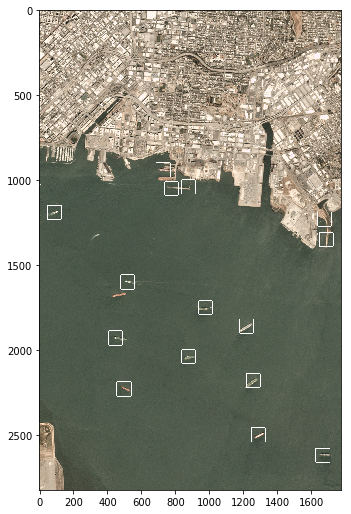

In [36]:
picture_tensor = picture_tensor.transpose(1,2,0)
picture_tensor.shape

(1777, 2825, 3)

plt.figure(1, figsize = (15, 30))

plt.subplot(3,1,1)
plt.imshow(picture_tensor)

plt.show()

